In [1]:
import torch
from spherebsde import nn, utils
import matplotlib.pyplot as plt

In [2]:
def u0(x):
    x_polar = utils.polar_corr(x)
    return 2/torch.pi**2/torch.sin(x_polar[:,:1])*(x_polar[:,:1]>torch.pi/4)*(x_polar[:,:1]<torch.pi/2)

def xb(x):
    x_polar = utils.polar_corr(x)
    in_ornot = x_polar[:,0] < torch.pi/2
    xb_ = x_polar.clone()
    xb_[:,0] = torch.pi/2
    xb_ = utils.transform_x(xb_)
    nb_ = torch.cat([xb_[:,:1]*xb_[:,2:],xb_[:,1:2]*xb_[:,2:],-xb_[:,:2].norm(dim=1,keepdim=True)**2],dim=1)
    nb_ = nb_ / nb_.norm(dim=1,keepdim=True)
    return xb_, nb_, in_ornot

def sample_on_hemisphere(r,n):
    u1 = torch.rand([n])
    u2 = torch.rand([n])*r
    phi = 2 * torch.pi * u1
    theta = torch.arccos(1 - u2)
    x = torch.sin(theta) * torch.cos(phi)
    y = torch.sin(theta) * torch.sin(phi)
    z = torch.cos(theta)
    return torch.stack([x,y,z],dim=1)

def data_gen(batch):
    x = sample_on_hemisphere(1,batch)
    return x

spherebsde = nn.SBeehive(
    u0 = u0,
    t = torch.tensor(1.),
    D = torch.tensor(0.1),
    data_gen = data_gen,
    N = 100,
    xb = xb
)

In [3]:
train_params = {
    'epoch': 10**4,
    'batch': 256,
    'lr': 1e-3
}

loss_values = nn.train(
    spherebsde,
    train_params
)

10000/10000|##################################################|2164.61s  [Loss: 9.130517e-04]                          
Training has been completed.


In [4]:
theta = torch.linspace(0,torch.pi/2*(99/100),100)
phi = torch.linspace(0,torch.pi*2,200)
theta,phi = torch.meshgrid(theta,phi)
x_polar = torch.stack([theta.reshape(100*200),phi.reshape(100*200)],dim=1)
x = utils.transform_x(x_polar)
y = spherebsde.u(x).reshape([100,200])

d:\Anaconda3\envs\torch\Lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 1.0, 'Deep learning')

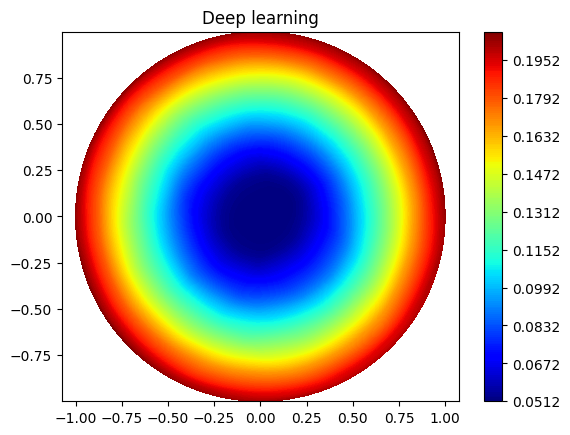

In [5]:
x = x.reshape([100,200,3])
plt.axis('equal')
plt.contourf(x[:,:,0],x[:,:,1],y.detach(),200,cmap='jet')
plt.colorbar()
plt.title('Deep learning')